In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load the data
df = pd.read_csv('combined_rainfall_data2.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")

# Create additional time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

# Create lag features (previous day's rainfall)
df['rainfall_lag1'] = df.groupby(['lat', 'lon'])['rainfall'].shift(1)

# Drop rows with NaN values
df['rainfall_lag1'] = df['rainfall_lag1'].fillna(0)
df['rainfall'] = df['rainfall'].fillna(0)

# Prepare features and target
features = ['lat', 'lon', 'year', 'month', 'day', 'dayofweek', 'rainfall_lag1']
X = df[features]
y = df['rainfall']

# Split the data into training and testing sets
X_train= X[:49674]
y_train= y[:49674]
X_test = X[49674:]
y_test = y[49674:]



In [2]:
df.head()

,date,lat,lon,rainfall,year,month,day,dayofweek,rainfall_lag1
0,1986-01-01,19.125,72.625,0.0,1986,1,1,2,0.0
1,1986-01-01,19.125,72.875,0.0,1986,1,1,2,0.0
2,1986-01-01,19.375,72.625,0.0,1986,1,1,2,0.0
3,1986-01-01,19.375,72.875,0.0,1986,1,1,2,0.0
4,1986-01-02,19.125,72.625,0.0,1986,1,2,3,0.0


<Axes: >

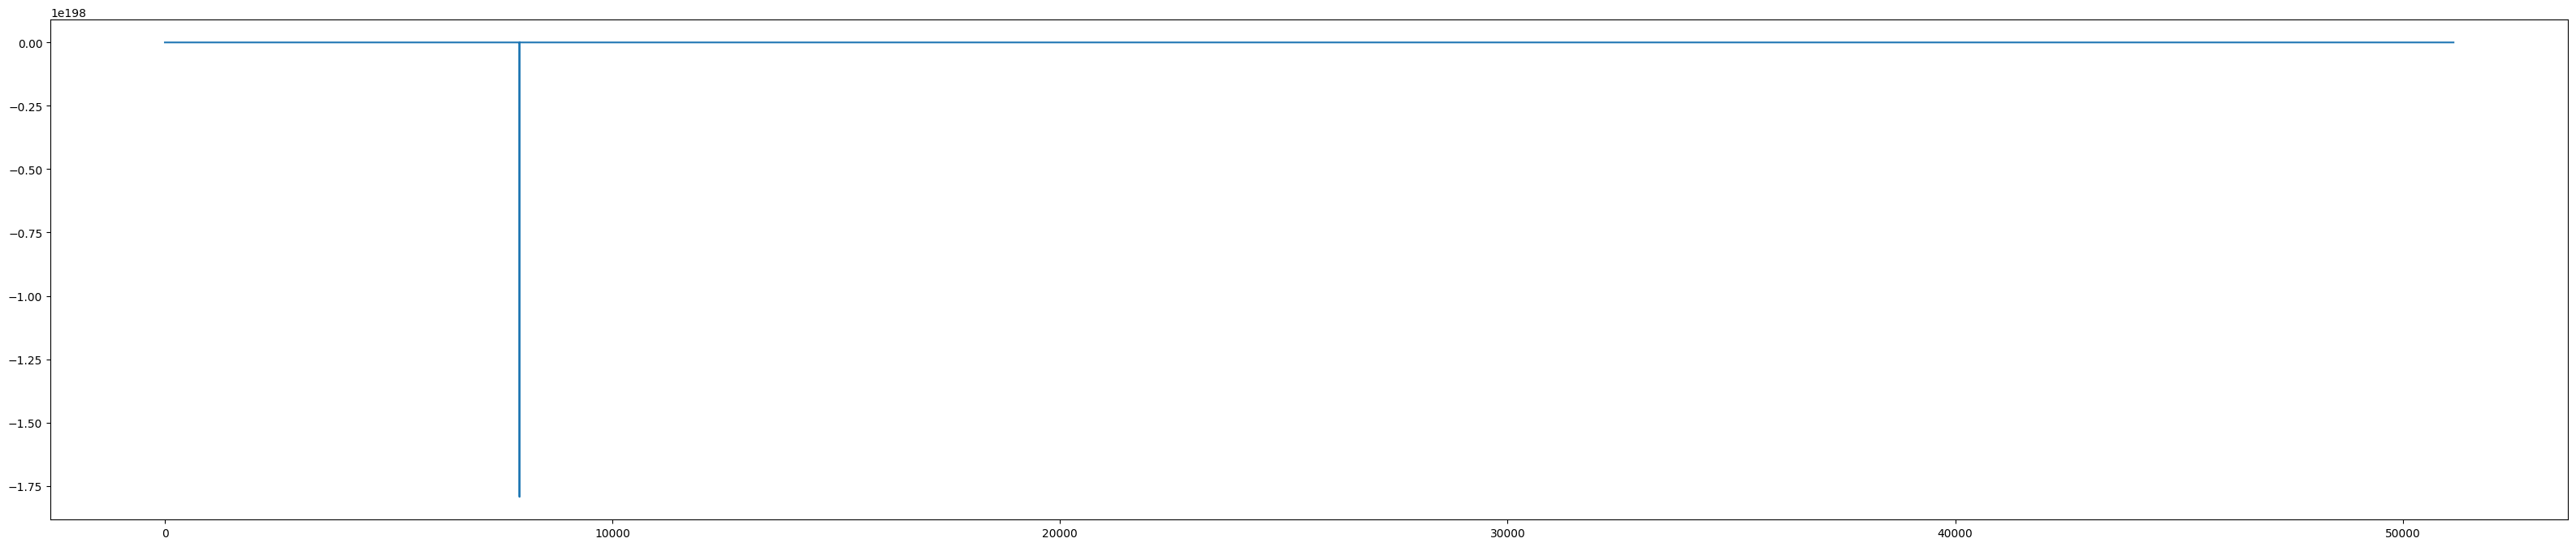

In [3]:
df['rainfall'].plot(figsize=(40,8))

In [4]:
df = df["rainfall"]

In [5]:
df.dropna(inplace=True)

In [7]:
df = np.array(df).reshape(-1,1)

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
scaled_data = sc.fit_transform(df)
scaled_data

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [9]:
X = []
backcandles = 20
for j in range(1):
  X.append([])
  for i in range(backcandles,scaled_data.shape[0]):
    X[j].append(scaled_data[i-backcandles:i,j])

X = np.moveaxis(X,[0],[2],)

X,yi = np.array(X), np.array(scaled_data[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
X.shape,y.shape

((51116, 20, 1), (51116, 1))

In [10]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train,X_test = X[:splitlimit],X[splitlimit:]
y_train,y_test = y[:splitlimit],y[splitlimit:]
print(X_train.shape)
print(y_train.shape)

40892
(40892, 20, 1)
(40892, 1)


In [11]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,TimeDistributed

In [12]:
import tensorflow as tf
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Input,Activation,concatenate

In [13]:
lstm_input = Input(shape=(backcandles,1),name='lstm_input')
inputs = LSTM(150,name='first_layer')(lstm_input)
inputs = Dense(1,name='dense_layer')(inputs)
output = Activation('linear',name='output')(inputs)
model = Model(inputs = lstm_input,outputs = output)
adam = optimizers.Adam()
model.compile(optimizer=adam,loss='mse')


In [14]:
print(model.output_shape)

(None, 1)


In [15]:
model.fit(x=X_train,y=y_train,batch_size=150,epochs=10)

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0579
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 4.7716e-05
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 1.0298e-04
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 4.1388e-06
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 2.1753e-05
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 6.8086e-05
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 2.0176e-05
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 8.2850e-06
Epoch 9/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 3.9352e-05
Epoch 10/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 5.3148e-05


In [16]:
pred = model.predict(X_test)

320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


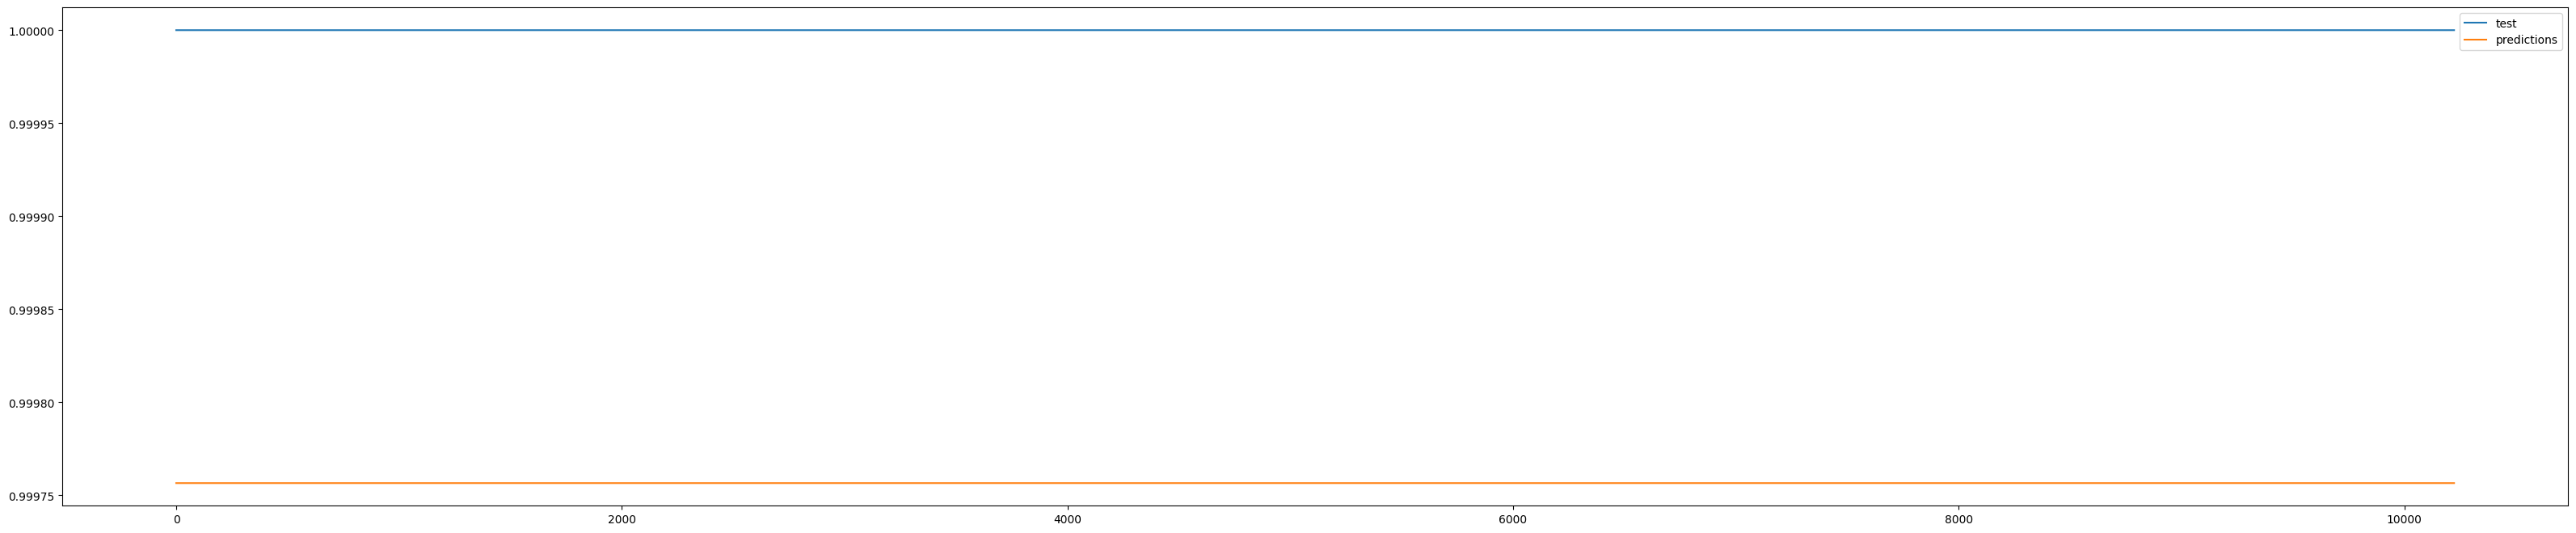

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,8))
plt.plot(y_test,label='test')
plt.plot(pred,label='predictions')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred,y_test)
mae

0.0002434253692626953

In [19]:
pred

array([[0.9997566],
       [0.9997566],
       [0.9997566],
       ...,
       [0.9997566],
       [0.9997566],
       [0.9997566]], dtype=float32)